In [1]:
from src.thickness_dataset import ThicknessDataset, ToTensor
from src.models import U_Net
from src.trainer import Trainer

import numpy as np
import matplotlib.pyplot as plt

import torch
from torch.utils.data import DataLoader
from torch import nn
from tqdm import tqdm
import pandas as pd

import albumentations as A
from albumentations.pytorch import ToTensorV2

PATH = "data\gen_data_6000_v2"

In [2]:
augs = A.Compose([A.Normalize(mean = (0, 0, 0),
                              std  = (1, 1, 1)),
                 ToTensorV2()])
thickness_dataset = ThicknessDataset(PATH, transform=augs)

# Calculate mean and std
image_loader = DataLoader(thickness_dataset, 
                          batch_size  = 128, 
                          shuffle     = False, 
                          num_workers = 4,
                          pin_memory  = True)

# placeholders
psum    = torch.tensor([0.0, 0.0, 0.0])
psum_sq = torch.tensor([0.0, 0.0, 0.0])

# loop through images
for inputs in tqdm(image_loader):
    psum    += inputs['img'].sum(axis        = [0, 2, 3])
    psum_sq += (inputs['img'] ** 2).sum(axis = [0, 2, 3])

# pixel count
count = len(thickness_dataset) * 128 * 128

# mean and std
total_mean = psum / count
total_var  = (psum_sq / count) - (total_mean ** 2)
total_std  = torch.sqrt(total_var)

100%|██████████| 52/52 [00:31<00:00,  1.64it/s]


In [3]:
train_split = 0.7
valid_split = 0.1

HUMAN_SAMPLE_PATH = "data\human_samples"
augs = A.Compose([A.Normalize(mean = total_mean,
                              std  = total_std),
                 ToTensorV2()])
thickness_dataset = ThicknessDataset(HUMAN_SAMPLE_PATH, transform=augs)


test_dataloader = DataLoader(thickness_dataset, batch_size=128)
print("# of samples in test set:", len(thickness_dataset))

# of samples in test set: 10


In [4]:
path = "models\Full train\model_20230301-145022_114"
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

model = U_Net()

criterion = nn.MSELoss()
model = model.to(device)
model.load_state_dict(torch.load(path))
model.eval()
trained_model = model

Using cuda device


In [5]:
# Get the masked loss for the test set quantative evaluation 
# https://torchmetrics.readthedocs.io/en/stable/image/peak_signal_noise_ratio.html
from skimage.metrics import structural_similarity as ssim
from src.evaluation import mse_loss_with_nans
from torchmetrics import PeakSignalNoiseRatio
full_loss = 0
fullstrsim = 0
full_mape = 0
batches = 0
mean_abs_percentage_error = PeakSignalNoiseRatio().to(device)

with torch.no_grad():
    for data in test_dataloader:
        images, labels = data['img'].to(device, dtype=torch.float), data['thick_map'].to(device, dtype=torch.float)
        outputs = trained_model(images)
        masked_loss = mse_loss_with_nans(outputs, labels)
        mape = mean_abs_percentage_error(outputs, labels)
        strsim = 0 
        for i in range(labels.cpu().numpy().shape[0]):
            strsim += ssim(outputs[i].cpu().numpy()[0], labels[i].cpu().numpy()[0])

        fullstrsim += strsim/labels.cpu().numpy().shape[0]
        full_mape += mape
        full_loss += masked_loss
        batches += 1
print("Test SSIM: {}".format(fullstrsim/batches))
print("Test loss: {}".format(full_loss/batches))
print("Test MAPE: {}".format(full_mape/batches))

Test SSIM: 0.9720226434071184
Test loss: 0.004953238647431135
Test MAPE: 30.865392684936523


In [6]:
label_dict = {"red": 0, "blue": 1}

df = pd.read_csv("human_sample_actuals.csv", index_col=0)
# sort the idx
df = df.sort_index()
# apply label_dict to label
df["label"] = df["label"].apply(lambda x: label_dict[x])
# convert tuple string to tuple on the thickness column
df["thicker"] = df["thicker"].apply(lambda x: eval(x))
df["thinner"] = df["thinner"].apply(lambda x: eval(x))
# calculate the thickness of the human samples
with torch.no_grad():
    for data in test_dataloader:
        samples = data
        images, labels = data['img'].to(device, dtype=torch.float), data['thick_map'].to(device, dtype=torch.float)
        outputs = trained_model(images)

    # we loop thru every sample in the batch and retrieve the thickness of both points and check that the thicker one is greater than the thinner one
correct = 0
for i in range(labels.cpu().numpy().shape[0]):
    pred = outputs[i].cpu().numpy()
    thicker = df["thicker"][i]
    thinner = df["thinner"][i]
    thick_pred = pred[0][thicker[0]][thicker[1]]
    thin_pred = pred[0][thinner[0]][thinner[1]]
    if thick_pred > thin_pred:
        correct += 1
print("Accuracy: {}".format(correct/labels.cpu().numpy().shape[0]))

Accuracy: 1.0


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(3, 128, 128)
Correctly predicted 0.08489247 > 0.04776931


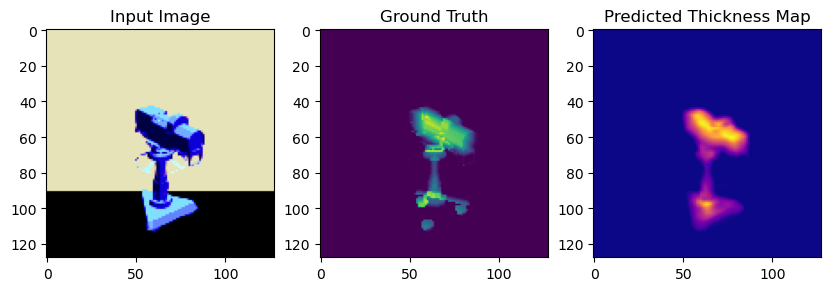

Structure Simililarity:  0.9716728815225024


In [7]:
# test visualisation/ qualitative evaluation
from skimage.metrics import structural_similarity as ssim

idx = 2
# sample = samples[idx]
output = outputs[idx]
with torch.no_grad():
    image, label = samples['img'][idx].to(device, dtype=torch.float), samples['thick_map'][idx].to(device, dtype=torch.float)
    image = image.cpu().numpy()
    label = label.cpu().numpy()
    output = output.cpu().numpy()
    print(image.shape)
    fig = plt.figure(figsize=(10,10))
    
    plt.subplot(1,3,1)
    # convert image tensor format to numpy array
    image=np.swapaxes(image,0,1)
    image=np.swapaxes(image,1,2)
    plt.imshow(image)
    plt.title('Input Image')
    plt.subplot(1,3,2)
    plt.imshow(label[0])
    plt.title('Ground Truth')
    plt.subplot(1,3,3)
    plt.imshow(output[0], cmap='plasma')
    # add a single point to the image
    thick_pt = df.loc[idx, "thicker"]
    thinner_pt = df.loc[idx, "thinner"]
    plt.scatter(thick_pt[1], thick_pt[0], c='r', s=0.5)
    plt.scatter(thinner_pt[1], thinner_pt[0], c='b', s=0.5)
    thickpred = output[0][thick_pt[0]][thick_pt[1]]
    thinnerpred = output[0][thinner_pt[0]][thinner_pt[1]]
    if thickpred > thinnerpred:
        print("Correctly predicted", thickpred, ">", thinnerpred)
    else:
        print("Incorrectly predicted", thickpred, "<", thinnerpred)

    plt.title('Predicted Thickness Map')

    plt.show()
print("Structure Simililarity: ",ssim(label[0], output[0].reshape(128,128)))